In [1]:
%matplotlib inline

## Get all diagnostic company info

In [3]:
import pycrunchbase
reload(pycrunchbase)
import json
import os
import requests
import time 
import sqlite3
import datetime

conn = sqlite3.connect('crunchbase.db')
cur = conn.cursor()
# cur.execute('DROP TABLE IF EXISTS companies ')
# cur.execute('DROP TABLE IF EXISTS fundraises ')
# cur.execute('DROP TABLE IF EXISTS exits ')

cur.execute('CREATE TABLE IF NOT EXISTS companies (id INTEGER PRIMARY KEY, name TEXT UNIQUE,  \
            founded_on INTEGER, rounds INTEGER, total_raised INTEGER, exit TEXT, exit_time INT, exit_price INT)')
cur.execute('CREATE TABLE IF NOT EXISTS fundraises \
            (round_id INTEGER PRIMARY KEY, company INTEGER, type TEXT, round TEXT, \
            amount REAL, time INTEGER)')
cur.execute('CREATE TABLE IF NOT EXISTS exits (company INTEGER, type TEXT, time INTEGER)')

conn.commit()
conn.close()


def get_uuid(obj):
    return obj[0].uuid



print "started"


conn = sqlite3.connect('crunchbase.db')
cur = conn.cursor()
Health_diagnostics = '8c1b0c584cc65d0a0208f656f91e4c82'
Biotechnology = '588427287ab95bd1bb67e8e55f6520a0'
cb = pycrunchbase.CrunchBase('ac51fb43c39076f46b9b3e2d04237b23')

counter = 0
other_counter = 0
company_list = []

#get a list of all the biotechnology companies


for page in range(1,7):        
    request_string = "https://api.crunchbase.com/v/2/organizations?category_uuids=3f21415b57846be63722eb189190b7cd&user_key=ac51fb43c39076f46b9b3e2d04237b23&page="+str(page) 
    company_request = requests.get(request_string)
    if page == 5:
        start=150
    else:
        start=0
    for item in company_request.json()['data']['items'][start:]:

        counter +=1
        if counter == 45:
            counter = 0
            other_counter +=1
            print other_counter
#             time.sleep(60)


        #get the organization object for each biotech company
        try:
            org = cb.organization(item['path'][13:])
        except:
            time.sleep(120)
            try:
                org = cb.organization(item['path'][13:])
            except:
                continue

                

        
        if not org.description:
            continue
        if org.funding_rounds and ('diagnostic' in org.description or 'diagnostic' in org.name):
            #if it seems like a diagnostic start-up (fundraise + diagnostic description) add to list
            company_link = item[13:]
            company_list.append(company_link)

            if org.founded_on:
                founding_date = int(org.founded_on.strftime('%Y'))
            else:
                founding_date = None

            try:
                cur.execute('INSERT INTO companies (name, founded_on, rounds, total_raised) VALUES (?,?,?,?)', \
                        (company_link, founding_date,len(org.funding_rounds), org.total_funding_usd) )

            except:
                continue

            #input acquisition data
            if org.ipo:
                current_ipo = cb.ipo(org.ipo[0].uuid)
                if current_ipo.went_public_on and org.founded_on:
                    ipo_date = datetime.datetime.strptime(current_ipo.went_public_on, '%Y-%m-%d')
                    acq_time = (ipo_date - org.founded_on).days
                else:
                    acq_time = None
                    ipo_date = None
                cur.execute('UPDATE companies SET exit=?, exit_time=? WHERE name=?',\
                            ('IPO',ipo_date,company_link))

            elif org.acquired_by:
                acquisition = cb.acquisition(org.acquired_by[0].uuid)

                if acquisition.announced_on and org.founded_on:
                    acq_time = (acquisition.announced_on - org.founded_on).days
                    acq_date = acquisition.announced_on
                else:
                    acq_date = None
                try:
                    cur.execute('UPDATE companies SET exit=?, exit_time=? WHERE name=?',\
                            ('acquired by '+str(acquisition.acquirer[0]),acq_date,company_link))
                except:
                    cur.execute('UPDATE companies SET exit=?, exit_time=? WHERE name=?',\
                            ('acquired by ',acq_date,company_link))



                cur.execute('UPDATE companies SET exit_price=? WHERE name=?',\
                            ( acquisition.price,company_link))



            elif org.closed_on:
                cur.execute('UPDATE companies SET exit=? WHERE name = ?',\
                            ('closed',company_link))


            conn.commit()
            cur.execute('SELECT id FROM companies WHERE name=?',(company_link,))
            company_ID = cur.fetchone()[0]
            print company_link, "companies", len(company_list)




        #loop through all fundraising rounds and get info
#             for fr in org.funding_rounds:
#                 counter +=1
#                 if counter == 40:
#                     counter = 0
#                     time.sleep(60)
#                 rounds = cb.funding_round(fr.uuid)
#                 time_passed = rounds.announced_on - org.founded_on
#                 cur.execute('INSERT INTO fundraises (company, type, round, amount, time) VALUES (?, ?, ?, ?, ?)',\
#                             (company_ID, rounds.funding_type, rounds.series, rounds.money_raised_usd, time_passed.days))
            conn.commit()
conn.close()
        


### get all funding rounds for companies

In [2]:
conn = sqlite3.connect('crunchbase.db')
cur = conn.cursor()
cur.execute('CREATE TABLE IF NOT EXISTS fundraises \
            (round_id INTEGER PRIMARY KEY, company INTEGER, type TEXT, round TEXT, \
            amount REAL, time INTEGER, investors TEXT)')

cur.execute('SELECT name FROM companies')
count = 0
comp_names = []
for row in cur:
    comp_names.append(row[0])
    
print "started"
for name in comp_names[160:]:
    try:
        org = cb.organization(name)
    except:
        time.sleep(90)
        org = cb.organization(name)
        
    print name
    #Get company ID
    cur.execute("SELECT id FROM companies WHERE name=(?)",(name,))
    company_ID = cur.fetchone() 
    cur.execute("DELETE FROM fundraises WHERE company = (?)",company_ID)
    
    
    #loop through all fundraising rounds and get info
    for fr in org.funding_rounds:
        
        try:
            rounds = cb.funding_round(fr.uuid)
        except:
            time.sleep(90)
            rounds = cb.funding_round(fr.uuid)
            
        #get time round was raised
        try:
            announced = rounds.announced_on
        except:
            announced=None
            
        #get type
        try: 
            funding_type = rounds.funding_type
        except:
            funding_type=None
            
        #GET SERIES
        try:
            series = rounds.series
        except:
            series = None
            
        #Get Money
        try:
            amount = rounds.money_raised_usd
        except:
            amount = None
         
        #GET INVESTORS
        investors = ''
        if rounds.investments:
            for inv in rounds.investments:
                investors=investors +', ' +str(inv.investor)
        
        
        #THROW IT ALL IN THERE
        try:
            cur.execute('INSERT INTO fundraises (company, type, round, amount, time, investors) VALUES (?, ?, ?, ?, ?, ?)',\
                    (company_ID[0], funding_type, series, amount, announced, investors))
        except:
            cur.execute('INSERT INTO fundraises (company, type, round, amount, time) VALUES (?, ?, ?, ?, ?)',\
                    (company_ID[0], funding_type, series, amount, announced))

        conn.commit()
conn.close()

In [4]:
import pycrunchbase
reload(pycrunchbase)
import json
import os
import requests
import time 
import sqlite3
import datetime

conn = sqlite3.connect('crunchbase.db')
cur = conn.cursor()
cb = pycrunchbase.CrunchBase('ac51fb43c39076f46b9b3e2d04237b23')

    

comp='3'
cur.execute("UPDATE companies SET exit_price = (?) WHERE id=(?)",(96*1000000, comp) )
conn.commit()
       
cur.execute('SELECT * FROM companies WHERE exit LIKE "%IPO%" ')
for row in cur:
    print row

(3, u'xdx', 2000, 8, 126397292, u'IPO', None, 96000000)
(12, u'alliqua', None, 7, 40816578, u'IPO', None, None)
(16, u'bg-medicine', 2000, 7, 96129290, u'IPO', u'2011-02-04 00:00:00', 270000000)
(17, u'autogenomics', 1999, 5, 55153254, u'IPO', u'2014-10-08 00:00:00', None)
(22, u'horizon-discovery', 2007, 5, 50251719, u'IPO', u'2014-03-28 00:00:00', 162000000)
(23, u'helicos-biosciences', None, 1, 10000008, u'IPO', None, 730000000)
(24, u'diadexus', 1997, 4, 68700000, u'IPO', u'1999-06-30 00:00:00', 1000000000)
(25, u'hologic', 1985, 1, 450000000, u'IPO', u'1990-03-09 00:00:00', None)
(26, u'combimatrix', None, 5, 20952124, u'IPO', None, None)
(27, u'veracyte', 2008, 3, 70950000, u'IPO', u'2013-10-30 00:00:00', 275000000)
(33, u'pressure-biosciences', 1978, 8, 9428756, u'IPO', u'2003-01-10 00:00:00', None)
(36, u'sequenom', 1994, 3, 183117265, u'IPO', u'2000-02-11 00:00:00', None)
(39, u'biotime', 1992, 6, 60330000, u'IPO', None, None)
(40, u'exact-sciences', 1995, 1, 8200000, u'IPO', 

### identify dormant companies as companies who have not exited or raised a round since 2012

In [ ]:
def mark_as_closed(ids):
    cur.execute('UPDATE companies SET exit=? WHERE id = ?',('dormant',ids))

cutoff = datetime.datetime.strptime('2012-01-01','%Y-%m-%d')
for ids in list(companies.index.values):
    closed=1
    cur.execute('SELECT time FROM fundraises WHERE company=?',(ids,))
    for row in cur:
        if datetime.datetime.strptime(row[0][:10],'%Y-%m-%d') > cutoff:
            closed=0

    if closed:
        cur.execute('SELECT exit FROM companies WHERE id=?',(ids,))
        if cur.fetchone()[0] == None:
            mark_as_closed(ids)


### Pull out companies and group by exit type for analysis

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import sqlite3
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

IPO_companies = pd.read_sql_query('SELECT * FROM companies '  
                                  'WHERE exit LIKE "%ipo%" ', \
                                  conn, index_col='id')

acq_companies = pd.read_sql_query('SELECT * FROM companies ' 
                                  'WHERE exit LIKE "%acquired%" ', \
                                  conn, index_col='id')

closed_companies = pd.read_sql_query('SELECT * FROM companies ' 
                                  'WHERE exit LIKE "%closed%" ', \
                                  conn, index_col='id')

dormant_companies = pd.read_sql_query('SELECT * FROM companies ' 
                                  'WHERE exit LIKE "%dormant%" ', \
                                  conn, index_col='id')

acq_companies.dropna(subset=['exit_time'], inplace = True)
IPO_companies.dropna(subset=['exit_time'], inplace = True)



### Exits vs time

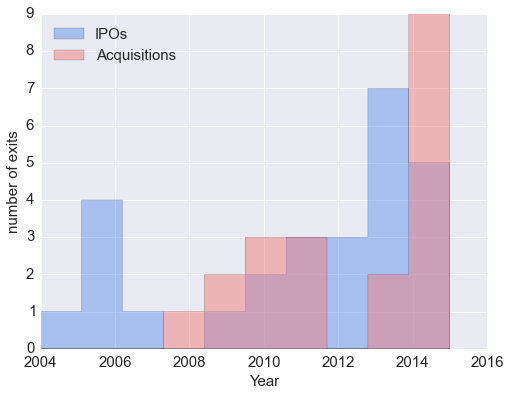

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

IPO_times = [int(x[:4]) for x in IPO_companies['exit_time'].tolist()]
Acq_times = [int(x[:4]) for x in acq_companies['exit_time'].tolist()]

# y,binEdges=np.histogram(data,bins=100)
# bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
# p.plot(bincenters,y,'-')

bins = np.linspace(2004, 2015, 11)

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.rc('legend',fontsize=15)
plt.rc('axes',labelsize=15)

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.hist(IPO_times, bins, color="#6495ED", alpha=.5, histtype = 'stepfilled')
plt.hist(Acq_times, bins, color="#F08080", alpha=.5, histtype = 'stepfilled')


ax = plt.gca()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.xlabel("Year")
plt.ylabel("number of exits") 
plt.legend(['IPOs','Acquisitions'], loc=2)

plt.show()




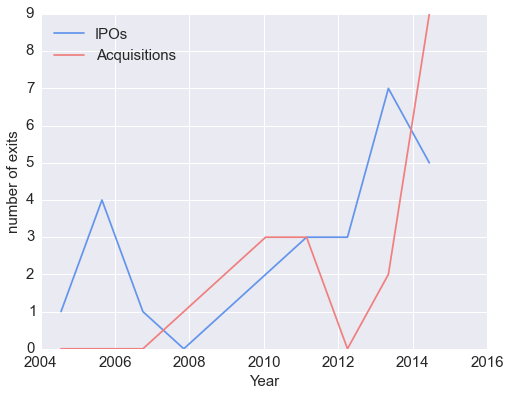

In [9]:

# IPO_freqs = plt.hist(IPO_times, bins, color="#6495ED", alpha=.5, histtype = 'step')[0]
# Acq_freqs = plt.hist(Acq_times, bins, color="#F08080", alpha=.5, histtype = 'step')[0]

bincenters = 0.5*(bins[1:]+bins[:-1])

# plt.rc('xtick', labelsize=15) 
# plt.rc('ytick', labelsize=15)
# plt.rc('legend',fontsize=15)
# plt.rc('axes',labelsize=15)

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(bincenters, IPO_freqs, '-', color='#6495ED')
plt.plot(bincenters, Acq_freqs, '-',color='#F08080')

ax = plt.gca()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.xlabel("Year")
plt.ylabel("number of exits") 
plt.legend(['IPOs','Acquisitions'], loc=2)

plt.show()

### Grab companies that started since 1998

In [27]:
import pandas as pd
import numpy as np
acq_companies = pd.read_sql_query('SELECT * FROM companies ' 
                                  'WHERE exit LIKE "%acquired%" ', \
                                  conn, index_col='id')


IPO_companies = pd.read_sql_query('SELECT * FROM companies '  
                                  'WHERE exit LIKE "%ipo%"', \
                                  conn, index_col='id')


closed_companies = pd.read_sql_query('SELECT * FROM companies ' 
                                  'WHERE exit LIKE "%closed%" ', \
                                  conn, index_col='id')

dormant_companies = pd.read_sql_query('SELECT * FROM companies ' 
                                  'WHERE exit LIKE "%dormant%" ', \
                                  conn, index_col='id')

IPO_companies=IPO_companies[IPO_companies['founded_on']>1998]
# acq_companies=acq_companies[acq_companies['founded_on']>1998]
closed_companies=closed_companies[closed_companies['founded_on']>1998]
dormant_companies=dormant_companies[dormant_companies['founded_on']>1998]


# IPO2=IPO_companies[np.isnan(IPO_companies['founded_on'])]
# IPO_companies = pd.concat([IPO1,IPO2])
IPO_companies=IPO_companies[IPO_companies['exit_price']>1]
# acq_companies1=acq_companies[acq_companies['founded_on']<1]
acq_companies1 = acq_companies[np.isnan(acq_companies['founded_on'])]
acq_companies2=acq_companies[acq_companies['founded_on']>1998]
acq_companies = pd.concat([acq_companies1, acq_companies2])
IPO_companies

,name,founded_on,rounds,total_raised,exit,exit_time,exit_price
id,,,,,,,
3,xdx,2000,8,126397292,IPO,None,96000000
16,bg-medicine,2000,7,96129290,IPO,2011-02-04 00:00:00,270000000
22,horizon-discovery,2007,5,50251719,IPO,2014-03-28 00:00:00,162000000
27,veracyte,2008,3,70950000,IPO,2013-10-30 00:00:00,275000000
43,nanosphere,1999,1,30200000,IPO,2007-11-01 00:00:00,101000000
53,stemline-therapeutics,2003,4,15090000,IPO,2013-01-29 00:00:00,201000000
66,opko-health,2005,2,206000000,IPO,1997-03-07 00:00:00,1700000000
72,oxford-immunotec,2002,4,106550010,IPO,2013-11-22 00:00:00,286000000
89,invitae-corporation,2012,5,195502111,IPO,2015-02-12 00:00:00,585000000


### Look at money raised vs number of funding rounds

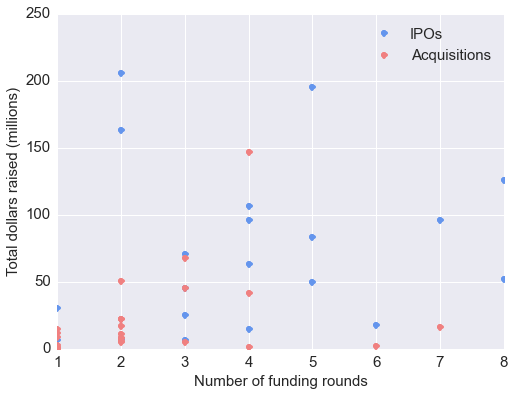

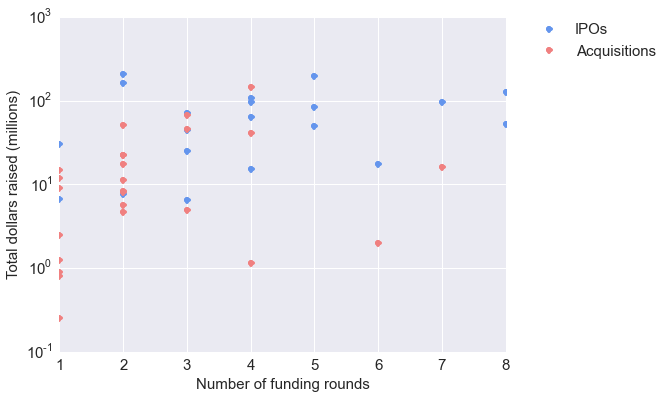

In [38]:

IPO_rounds = np.array(IPO_companies['rounds'])
IPO_funding = np.array(IPO_companies['total_raised'])

acq_rounds = np.array(acq_companies['rounds'])
acq_funding = np.array(acq_companies['total_raised'])

plt.figure(num=None, figsize=(8, 6), dpi=80)
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.plot(IPO_rounds, IPO_funding/float(1000000), 'o', color = '#6495ED')
plt.plot(acq_rounds, acq_funding/float(1000000), 'o', color = '#F08080')
plt.legend(['IPOs','Acquisitions'])
plt.xlabel("Number of funding rounds")
plt.ylabel("Total dollars raised (millions)")
plt.show()

plt.figure(num=None, figsize=(8, 6), dpi=80)
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.semilogy(IPO_rounds, IPO_funding/float(1000000), 'o', color = '#6495ED')
plt.semilogy(acq_rounds, acq_funding/float(1000000), 'o', color = '#F08080')
plt.legend(['IPOs','Acquisitions'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Number of funding rounds")
plt.ylabel("Total dollars raised (millions)")
plt.show()

### group companies by amount of money raised (in 4 bins) - look at exits for each bin

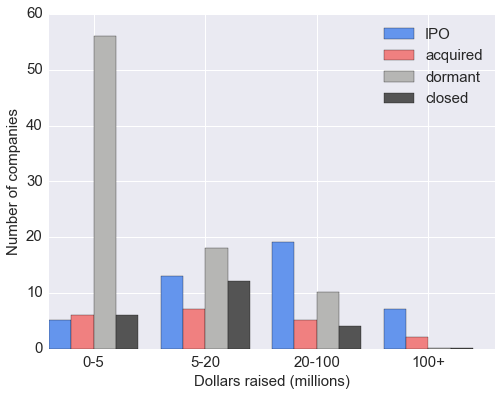

OrderedDict([('0-5', 6.1), ('5-20', 12.1), ('20-100', 4.1), ('100+', 0.1)])
OrderedDict([('0-5', 56.1), ('5-20', 18.1), ('20-100', 10.1), ('100+', 0.1)])


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
def funding_bins(data):
    funding_dict = OrderedDict([('0-5',.1), ('5-20',.1),('20-100',.1), ('100+',.1)])
    for i in data:
        if i < 5:
            funding_dict['0-5']+=1
        elif i<20:
            funding_dict['5-20']+=1
        elif i<100:
            funding_dict['20-100']+=1
        else:
            funding_dict['100+']+=1
    return funding_dict


IPO_rounds = np.array(IPO_companies['rounds'])
IPO_funding = np.array(IPO_companies['total_raised'])

acq_rounds = np.array(acq_companies['rounds'])
acq_funding = np.array(acq_companies['total_raised'])

closed_rounds = np.array(closed_companies['rounds'])
closed_funding = np.array(closed_companies['total_raised'])

dormant_rounds = np.array(dormant_companies['rounds'])
dormant_funding = np.array(dormant_companies['total_raised'])

IPO_dict = funding_bins(IPO_funding/1000000)
acq_dict = funding_bins(acq_funding/1000000)
closed_dict = funding_bins(closed_funding/1000000)
dormant_dict = funding_bins(dormant_funding/1000000)

plt.figure(num=None, figsize=(8, 6), dpi=80)
width = .2    
fig, ax = plt.subplots(figsize=(8, 6))
IPO = ax.bar(range(4), IPO_dict.values(), width, color='#6495ED')
acquired = ax.bar(np.array(range(4))+width, acq_dict.values(), width, color='#F08080')
dormant = ax.bar(np.array(range(4))+2*width, dormant_dict.values(), width, color='#B6B6B4')
closed = ax.bar(np.array(range(4))+3*width, closed_dict.values(), width, color='#545454')

    

#ax.xticks(range(len(MS_plot)), MS_plot.keys(), rotation=45)
ax.set_xticks(np.array(range(4))+2*width)
ax.set_xticklabels( IPO_dict.keys() )
ax.set_xlabel('Dollars raised (millions)')
ax.set_ylabel('Number of companies')
ax.legend(['IPO', 'acquired', 'dormant', 'closed'])

plt.show()
print closed_dict
print dormant_dict

### VC firms investing in diagnostics

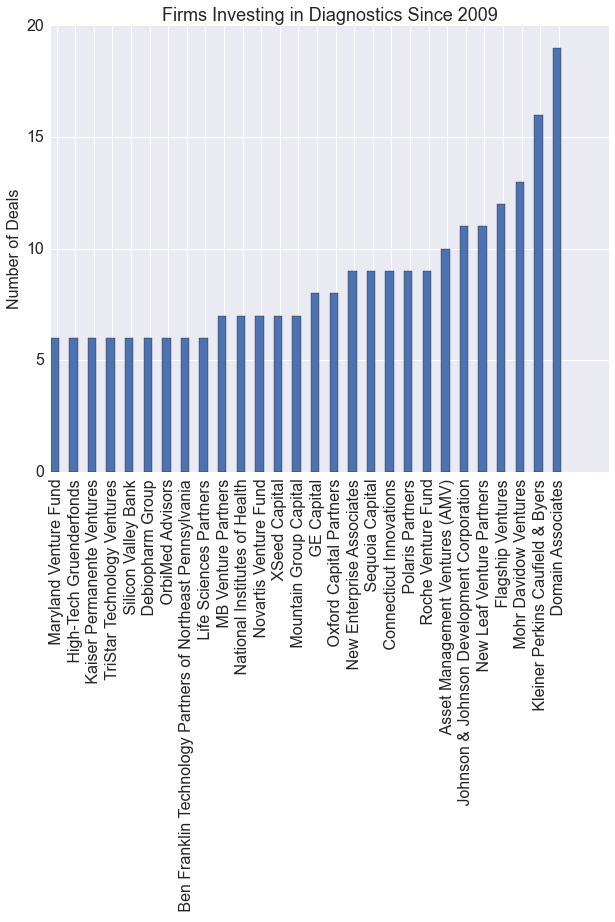

In [75]:
import operator
from collections import OrderedDict
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('axes',labelsize=16)

def bar_plt(data, ylabel, title, name=None, color=None):
    #data must be a dict, and each item in dict will be a bar
    plt.figure(num=None, figsize=(10, 8), dpi=2500)
    plt.bar(range(len(data)), data.values(), width = .45, color=color)
    plt.xticks(np.array(range(len(data)))+.325, data.keys(), rotation=90)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=18)
#     plt.savefig(name, dpi = 2000)
    plt.show()


conn = sqlite3.connect('crunchbase.db')
cur = conn.cursor()    
    
investor_dict={}
investor_names={}
years = range(2010, 2016, 1)
investor_counts = {}
for year in years:
    investor_dict[year] = 0
    investor_names[year]=[]
    cur.execute('SELECT time, investors FROM fundraises')
    for row in cur:
        if int(row[0][:4]) == year:
            try:
                inv = row[1].split(',')
            except:
                inv=[]

            if inv:
                for i in inv:
                    if i in investor_counts:
                        investor_counts[i]+=1
                    else:
                        investor_counts[i]=1

                    try:
                        if i not in investor_names[int(row[0][:4])]:
                            investor_names[int(row[0][:4])].append(i)
                            investor_dict[int(row[0][:4])]+=1
                    except:
                        pass
for k, v in investor_counts.items():
    if v<6:
        del investor_counts[k]
del investor_counts['']
sorted_inv = sorted(investor_counts.items(), key=operator.itemgetter(1))
sorted_inv = OrderedDict(sorted_inv)
# bar_plt(investor_dict, "Number of different investors", "Amount of Firms Investing in Diagnostics since 2009", name='Num_investors.png')
bar_plt(sorted_inv, "Number of Deals", "Firms Investing in Diagnostics Since 2009", name="num_deals.png")



### Look at return on capital for companies with exits

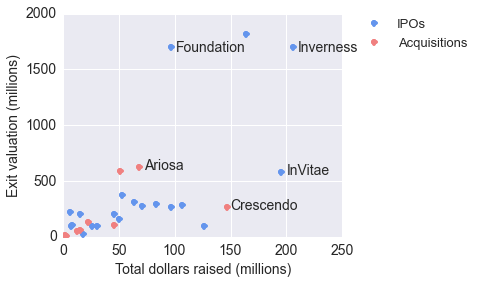

In [73]:
def sort_exits(exits):
    exits = exits[exits['total_raised']>1000000]
    exits.dropna(subset=['exit_price'], inplace = True)
    sorted_exits = exits.sort(['exit_price'])
    return sorted_exits

# IPO_exits = pd.read_sql_query('SELECT name, total_raised, exit_price FROM companies WHERE founded_on >1993 AND exit LIKE "%IPO%"', \
#                                   conn, )
# acq_exits = pd.read_sql_query('SELECT name, total_raised, exit_price FROM companies WHERE exit LIKE "%acquired%"', \
#                                  conn, )

sorted_IPOs = sort_exits(IPO_companies)
sorted_acq = sort_exits(acq_companies)


IPO_money_in = np.array(sorted_IPOs['total_raised'])
IPO_money_out = np.array(sorted_IPOs['exit_price'])

acq_money_out = np.array(sorted_acq['exit_price'])
acq_money_in = np.array(sorted_acq['total_raised'])

plt.figure(num=None, figsize=(5, 4), dpi=2500)
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.plot(IPO_money_in/float(1000000), IPO_money_out/float(1000000), 'o', color = '#6495ED')
plt.plot(acq_money_in/float(1000000), acq_money_out/float(1000000), 'o', color = '#F08080')
plt.legend(['IPOs','Acquisitions'],bbox_to_anchor=(1.05, 1), loc=2, fontsize=13, borderaxespad=0.)
plt.xlabel("Total dollars raised (millions)", size=14)
plt.ylabel("Exit valuation (millions)", size=14)
plt.figtext(.35, .36, "Ariosa", fontsize=14)
plt.figtext(.75, .34, "InVitae", fontsize=14)
plt.figtext(.59, .22, "Crescendo", fontsize=14)
plt.figtext(.44, .77, "Foundation", fontsize=14)
plt.figtext(.78, .77, "Inverness", fontsize=14)
# plt.savefig('invest_return.png', dpi = 2000)
plt.show()

In [13]:
sorted_IPOs

,name,founded_on,rounds,total_raised,exit,exit_time,exit_price
id,,,,,,,
115,stellar-biotechnologies,1999,6,17566976,IPO,2010-04-30 00:00:00,27000000
3,xdx,2000,8,126397292,IPO,None,96000000
404,cancer-genetics,1999,1,6618000,IPO,2013-06-06 00:00:00,96000000
148,trovagene,1999,3,25358200,IPO,2012-06-08 00:00:00,98000000
43,nanosphere,1999,1,30200000,IPO,2007-11-01 00:00:00,101000000
215,atossa-genetics,2009,2,7600000,IPO,2012-11-08 00:00:00,105000000
22,horizon-discovery,2007,5,50251719,IPO,2014-03-28 00:00:00,162000000
53,stemline-therapeutics,2003,4,15090000,IPO,2013-01-29 00:00:00,201000000
101,newlink-genetics,1999,3,45214105,IPO,2011-11-14 00:00:00,207000000


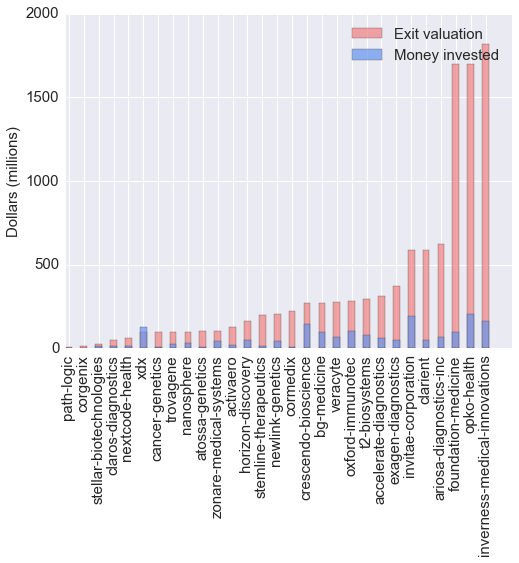

In [41]:
exits = pd.concat([IPO_companies, acq_companies])
sorted_exits = sort_exits(exits)

money_in = np.array(sorted_exits['total_raised'])
money_out = np.array(sorted_exits['exit_price'])                            


plt.figure(num=None, figsize=(8, 6), dpi=80)
width = .45    
fig, ax = plt.subplots(figsize=(8, 6))
exit = ax.bar(range(len(money_in)), money_out/1000000, width, color='#F08080', alpha=.7, )
raised = ax.bar(range(len(money_in)), money_in/1000000, width, color='#6495ED', alpha=.7, )
  

#ax.xticks(range(len(MS_plot)), MS_plot.keys(), rotation=45)
# ax.set_xticks(np.array(range(len(money_in))))
# ax.set_xticklabels( list(sorted_exits['name']), rotation=45 )
# ax.set_xlabel('Dollars raised (millions)')
plt.xticks(np.array(range(len(money_in)))+.225, np.array(sorted_exits['name']), rotation=90)
ax.set_ylabel('Dollars (millions)')
ax.legend(['Exit valuation', 'Money invested'])

plt.show()